The sole purpose of this file is to convert the CombinedCSI.mat file from the pipeline to a separate data.npy and mask.npy files for easier usage. You only have to insert the correct data folder name below and run the notebook. A CombinedCSI.mat file in that folder is required

In [1]:
import os, sys
import matplotlib.pyplot as plt

# 1) bestimme den Pfad zum Projekt-Root (eine Ebene höher)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# 2) füge ihn vor allen anderen Einträgen ein
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

In [13]:
import numpy as np
from data.transforms import StratifiedPixelSelection
from data.mrsi_2d_dataset import MRSiNDataset

# Test:
# transform = UniformPixelSelection(num_masked_pixels=30, window_size=3)
# print(transform)

data_all = np.load('../datasets/P03/data.npy')
#data_all = np.fft.fftshift(np.fft.fft(data_all, axis=-2), axes=-2)


# Dataset für XY-Slices ohne Patch
ds2d = MRSiNDataset(
    data=data_all,
    image_axes=(0,1),                     # X–Y-Ebenen
    fixed_indices= {
        0: 10,  # x-Achse -> 10
        1: 11,   # y-Achse -> 1
        2: 10,   # z-Achse -> 7
        3: 1,
        4: 7,
        5: 1    # D-Achse -> 2
    },                   # alle Achsen außer X,Y zufällig
    transform=StratifiedPixelSelection(num_masked_pixels=12, window_size=3),
    num_samples=5000
)



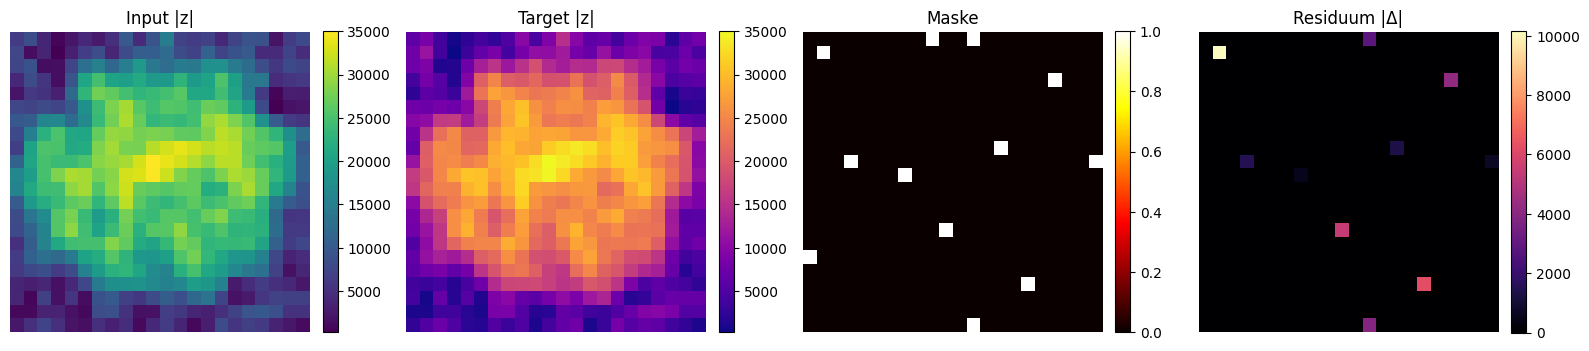

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Ein einzelnes Sample ziehen
inp, tgt, mask = ds2d[0]    # inp.shape == (2, H, W), tgt.shape == (2, H, W), mask.shape == (1, H, W)

# 2) In NumPy konvertieren
inp_np   = inp .numpy()         # shape (2, H, W)
tgt_np   = tgt .numpy()         # shape (2, H, W)
mask_np  = mask.squeeze(0).numpy()  # shape (H, W)

# 3) Magnitude berechnen (Absolutwert aus Real+Imag)
mag_inp  = np.sqrt(inp_np[0]**2 + inp_np[1]**2)
mag_tgt  = np.sqrt(tgt_np[0]**2 + tgt_np[1]**2)

# 4) Residuum berechnen: absolute Differenz
resid = np.abs(mag_tgt - mag_inp)

# 5) Plotten in 4 Spalten
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Input-Magnitude
im0 = axes[0].imshow(mag_inp, cmap='viridis')
axes[0].set_title("Input |z|")
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Target-Magnitude
im1 = axes[1].imshow(mag_tgt, cmap='plasma')
axes[1].set_title("Target |z|")
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Maske
im2 = axes[2].imshow(mask_np, cmap='hot')
axes[2].set_title("Maske")
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

# Residuum
im3 = axes[3].imshow(resid, cmap='magma')
axes[3].set_title("Residuum |Δ|")
axes[3].axis('off')
plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()





In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader

# ---------- 1. Dataset -------------------------------------------------
from data.transforms import StratifiedPixelSelection
from data.mrsi_2d_dataset import MRSi2Dataset   # oder MRSiNDataset, je nach Dateiname

data_all = np.load('../datasets/P03/data.npy')
data_all = np.fft.fftshift(np.fft.fft(data_all, axis=-2), axes=-2)

ds2d = MRSi2Dataset(
    data=data_all,
    image_axes=(3, 4),                       # (freq, T) – nur als Beispiel
    fixed_indices=None,
    transform=StratifiedPixelSelection(num_masked_pixels=12, window_size=3),
    num_samples= 32                          # reicht für einen Test
)

loader = DataLoader(ds2d, batch_size=4, shuffle=False)

# ---------- 2. Modell --------------------------------------------------
from models.unet2d import UNet2D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = UNet2D(in_channels=2, out_channels=2, features=(64, 128, 256)).to(device)
model.eval()
                                               # Inference‐Modus

# ---------- 3. Forward-Pass-Test --------------------------------------
inp, tgt, mask = next(iter(loader))     # ein Mini-Batch
inp = inp.to(device)                    # (B, 2, H, W)

with torch.no_grad():
    out = model(inp)                    # (B, 2, H, W)

print("Input  shape :", inp.shape)
print("Output shape :", out.shape)
print("Ein paar Output-Werte (Real-Kanal, erster Sample, 3×3):")
print(out[0, 0, :3, :3].cpu())


In [ ]:
from data.data_utils import *

train_data = ['P03','P04','P05','P06','P07']
val_data   = ['P08']

tdata = load_and_preprocess_data(
    folder_names = train_data,
    base_path = '../datasets',
    fourier_axes = None,
    normalize = True
)

In [ ]:
x,y,z,T,D= 10,11,10,7,4

Line = np.abs(tdata)[x,y,z,:,T,D]

plt.plot(Line)